In [1]:
from __future__ import print_function, division

import numpy as np

plot_to_pdf = True

if plot_to_pdf:
    import matplotlib as mpl
    mpl.use('pdf')
    
    import matplotlib.pyplot as plt
    
    plt.rc('font', family='serif', serif='Times')
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=8) # 10
    plt.rc('ytick', labelsize=8) # 10
    plt.rc('axes', labelsize=8) # 10
    plt.rc('legend', fontsize=8) # 10
    title_font_size = 8
    data_font_size = 8
else:
    import matplotlib.pyplot as plt

%matplotlib inline

import time
from collections import OrderedDict

import keras
from keras import backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from keras.utils import np_utils
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import seaborn as sns

%load_ext autoreload
%autoreload 2

import topological_memory_clustering
class_color = topological_memory_clustering.class_color

In [2]:
np.random.seed(42)

In [3]:
data = np.load('202007_datasets/result_quadrotor_dense_homology_random_starts_10k.npz')
print(list(data.keys()))

samples_X = data['samples_X'][:,:,:]
samples_U = data['samples_U']
labels = data['labels_3d']

sample_dim = samples_X.shape[0]
state_dim = samples_X.shape[1]
time_dim = samples_X.shape[2]
control_time_dim = samples_U.shape[1]
control_dim = samples_U.shape[2]

print(sample_dim, state_dim, time_dim, control_time_dim, control_dim)

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f7cd01a7dc0>)
5535 12 50 49 4


# Build X, Y vectors for learning

In [4]:
control_X_train, control_Y_train, control_X_test, control_Y_test = topological_memory_clustering.learning.dataset_to_learning_vectors_control(samples_X, samples_U)
state_X_train, state_Y_train, state_X_test, state_Y_test = topological_memory_clustering.learning.dataset_to_learning_vectors_state(samples_X, samples_U)

(4151, 12) (1384, 12) (4151, 196) (1384, 196)
(5535, 12, 50)
(4151, 12) (1384, 12) (4151, 600) (1384, 600)


# KNeighborsRegressor

In [5]:
knn_regressor_model_control = topological_memory_clustering.learning.train_kneighbors_model(control_X_train, control_Y_train, control_X_test, control_Y_test, debug=True)
knn_regressor_model_state = topological_memory_clustering.learning.train_kneighbors_model(state_X_train, state_Y_train, state_X_test, state_Y_test, debug=True)

KNN Regressor (k=1) - score: -0.14709855933675794
KNN Regressor (k=2) - score: 0.14090975808372183
KNN Regressor (k=3) - score: 0.240888797699798
KNN Regressor (k=4) - score: 0.2908213965802889
KNN Regressor (k=5) - score: 0.3131597690935609
KNN Regressor (k=6) - score: 0.3253998845323103
KNN Regressor (k=7) - score: 0.3407585268138111
KNN Regressor (k=8) - score: 0.35188086672774876
KNN Regressor (k=9) - score: 0.36104780000145453
Best k= 9
KNN Regressor (k=9) - score: 0.36104780000145453
KNN Regressor (k=1) - score: -0.10418329063777966
KNN Regressor (k=2) - score: 0.1849553422820941
KNN Regressor (k=3) - score: 0.26758080417904656
KNN Regressor (k=4) - score: 0.29957442146739754
KNN Regressor (k=5) - score: 0.32758134979348885
KNN Regressor (k=6) - score: 0.3490942661710444
KNN Regressor (k=7) - score: 0.36319352598278376
KNN Regressor (k=8) - score: 0.3665309743871989
KNN Regressor (k=9) - score: 0.37713327902164423
Best k= 9
KNN Regressor (k=9) - score: 0.37713327902164423


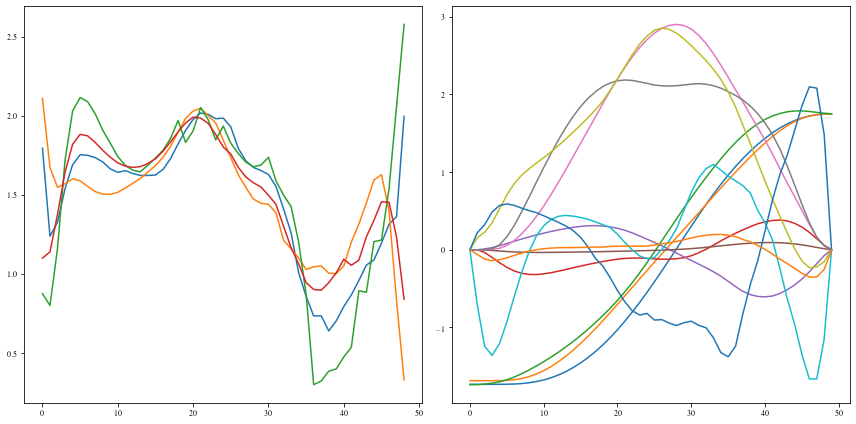

In [6]:
x_query = np.zeros((12,))
x_query[:3] = [-1.75,-1.75,-1.75]
x_query = x_query.reshape(1, -1)

fig = plt.figure()
fig.set_size_inches(12,6)
plt.subplot(121)
plt.plot(knn_regressor_model_control.predict(x_query).reshape(control_time_dim,control_dim))
plt.subplot(122)
plt.plot(knn_regressor_model_state.predict(x_query).reshape(state_dim,time_dim).T)
plt.tight_layout()
plt.show()

# Direct Learning

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               2600      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 600)               120600    
Total params: 163,400
Trainable params: 163,400
Non-trainable params: 0
_________________________________________________________________


/home/wxm/dev/exotica_ws/src/topological_memory_clustering/src/topological_memory_clustering/learning.py:115: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, history.history['loss'][0])


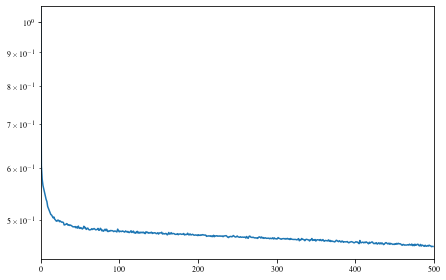

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               2600      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_5 (Dense)              (None, 196)               39396     
Total params: 82,196
Trainable params: 82,196
Non-trainable params: 0
_________________________________________________________________


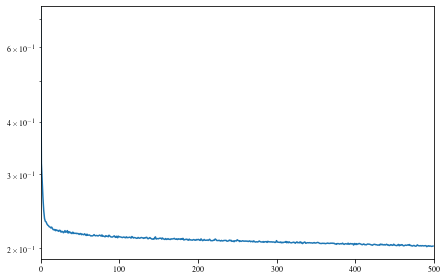

In [7]:
direct_learning_model_state, dlm_state_history = topological_memory_clustering.learning.train_direct_learning_model(state_X_train, state_Y_train, state_X_test, state_Y_test,
                                                                                                              n_hidden_layer_neurons=200,
                                                                                                              n_hidden_layers=1,
                                                                                                              hidden_layer_activation_function='relu',
                                                                                                              batch_size=64,
                                                                                                              epochs=500,
                                                                                                              debug=True)

direct_learning_model_control, dlm_control_history = topological_memory_clustering.learning.train_direct_learning_model(control_X_train, control_Y_train, control_X_test, control_Y_test,
                                                                                                                  n_hidden_layer_neurons=200,
                                                                                                                  n_hidden_layers=1,
                                                                                                                  hidden_layer_activation_function='relu',
                                                                                                                  batch_size=64,
                                                                                                                  epochs=500,
                                                                                                                  debug=True)

In [8]:
direct_learning_model_state.evaluate(state_X_test, state_Y_test)

44/44 [==============================] - 0s 554us/step - loss: 0.4798


0.4797724783420563

In [9]:
direct_learning_model_control.evaluate(control_X_test, control_Y_test)

44/44 [==============================] - 0s 431us/step - loss: 0.2215


0.2214602828025818

# Mixture-of-Experts with persistent homology separated clusters

In [10]:
# Load labelled data
labels_6d = data['labels_6d']
samples_X_6d = data['samples_X'][:,:,:]
samples_U_6d = data['samples_U']
num_clusters = data['num_classes_6d']

control_time_dim 49
control_dim 4
(5535, 12) (5535, 196) (5535, 12) (5535, 600)
Cluster 0 (808,)
Cluster 1 (570,)
Cluster 2 (1031,)
Cluster 3 (652,)
Cluster 4 (1143,)
Cluster 5 (1331,)
(5535, 12, 50)


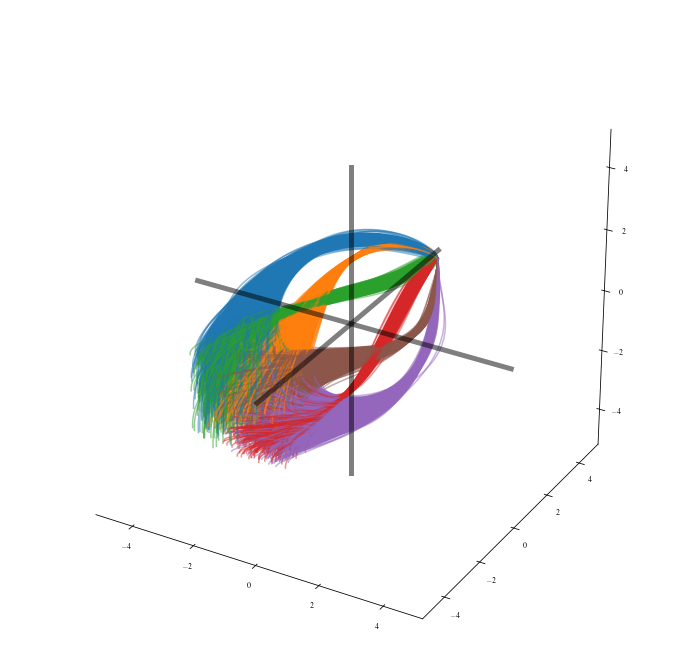

In [11]:
sample_dim = samples_X_6d.shape[0]
state_dim = samples_X_6d.shape[1]
time_dim = samples_X_6d.shape[2]
control_time_dim = samples_U_6d.shape[1]
control_dim = samples_U_6d.shape[2]
print("control_time_dim", control_time_dim)
print("control_dim", control_dim)

control_X, control_Y = topological_memory_clustering.learning.dataset_to_learning_vectors_without_test_train_split_control(samples_X_6d, samples_U_6d)
state_X, state_Y = topological_memory_clustering.learning.dataset_to_learning_vectors_without_test_train_split_state(samples_X_6d, samples_U_6d)
print(control_X.shape, control_Y.shape, state_X.shape, state_Y.shape)

control_X_clusters = []
control_Y_clusters = []
state_X_clusters = []
state_Y_clusters = []
for i in range(num_clusters):
    print("Cluster", i, labels_6d[labels_6d==i].shape)
    state_X_clusters.append(state_X[labels_6d==i,:])
    state_Y_clusters.append(state_Y[labels_6d==i,:])
    control_X_clusters.append(control_X[labels_6d==i,:])
    control_Y_clusters.append(control_Y[labels_6d==i,:])

colors_6d = topological_memory_clustering.clustering.get_colors_from_labels(labels_6d)
topological_memory_clustering.quadrotor.plot_state_trajectories_3d(samples_X_6d, colors_6d)
plt.show()

In [12]:
n_hidden_layers = 1
hidden_layer_activation_function = 'relu'

state_experts = []
control_experts = []
for i in range(num_clusters):
    n_hidden_layer_neurons = 50
    state_expert_model = keras.Sequential()
    state_expert_model.add(Dense(n_hidden_layer_neurons, input_dim=state_dim, activation=hidden_layer_activation_function))
    state_expert_model.add(Dense(units=time_dim*state_dim))
    state_expert_model.compile(loss='mse', optimizer='adam')
    #state_expert_model.summary()
    state_expert_X_train, state_expert_X_test, state_expert_Y_train, state_expert_Y_test = train_test_split(state_X_clusters[i],state_Y_clusters[i])
    state_expert_model.fit(state_expert_X_train, state_expert_Y_train, batch_size=64, epochs=500, verbose=0)
    print("State Expert",i,state_expert_model.evaluate(state_expert_X_test,state_expert_Y_test))
    state_experts.append(state_expert_model)

    control_expert_model = keras.Sequential()
    control_expert_model.add(Dense(n_hidden_layer_neurons, input_dim=state_dim, activation=hidden_layer_activation_function))
    control_expert_model.add(Dense(units=control_time_dim*control_dim))
    control_expert_model.compile(loss='mse', optimizer='adam')
    #control_expert_model.summary()
    control_expert_X_train, control_expert_X_test, control_expert_Y_train, control_expert_Y_test = train_test_split(control_X_clusters[i],control_Y_clusters[i])
    control_expert_model.fit(control_expert_X_train, control_expert_Y_train, batch_size=64, epochs=500, verbose=0)
    print("Control Expert",i,control_expert_model.evaluate(control_expert_X_test,control_expert_Y_test))
    control_experts.append(control_expert_model)

7/7 [==============================] - 0s 524us/step - loss: 0.0286
State Expert 0 0.02864120714366436
7/7 [==============================] - 0s 468us/step - loss: 0.0447
Control Expert 0 0.04468556493520737
5/5 [==============================] - 0s 522us/step - loss: 0.0337
State Expert 1 0.03374505415558815
5/5 [==============================] - 0s 621us/step - loss: 0.0411
Control Expert 1 0.04110218584537506
9/9 [==============================] - 0s 649us/step - loss: 0.0518
State Expert 2 0.051763974130153656
9/9 [==============================] - 0s 384us/step - loss: 0.0592
Control Expert 2 0.059214863926172256
6/6 [==============================] - 0s 704us/step - loss: 0.0487
State Expert 3 0.04871465638279915
6/6 [==============================] - 0s 560us/step - loss: 0.0658
Control Expert 3 0.06584013253450394
9/9 [==============================] - 0s 505us/step - loss: 0.0378
State Expert 4 0.03777870908379555
9/9 [==============================] - 0s 579us/step - loss: 0.

In [13]:
state_experts[0].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                650       
_________________________________________________________________
dense_7 (Dense)              (None, 600)               30600     
Total params: 31,250
Trainable params: 31,250
Non-trainable params: 0
_________________________________________________________________


In [14]:
control_experts[0].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                650       
_________________________________________________________________
dense_9 (Dense)              (None, 196)               9996      
Total params: 10,646
Trainable params: 10,646
Non-trainable params: 0
_________________________________________________________________


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 100)               1300      
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 606       
Total params: 1,906
Trainable params: 1,906
Non-trainable params: 0
_________________________________________________________________
44/44 [==============================] - 0s 343us/step - loss: 0.8780
Gating network score 0.877992570400238


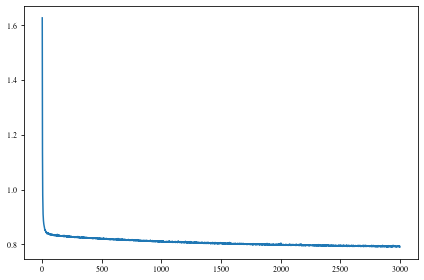

In [15]:
# Train classifier
expert_gating_network = keras.Sequential()
expert_gating_network.add(Dense(100, input_dim=state_dim, activation=hidden_layer_activation_function))
expert_gating_network.add(Dense(units=num_clusters, activation='softmax'))
expert_gating_network.compile(loss='categorical_crossentropy', optimizer='adam')
expert_gating_network.summary()
gating_X = state_X.copy()
gating_Y = keras.utils.to_categorical(labels_6d, num_classes=num_clusters, dtype='float32')

gating_X_train, gating_X_test, gating_Y_train, gating_Y_test = train_test_split(gating_X, gating_Y)

history = expert_gating_network.fit(gating_X_train, gating_Y_train, batch_size=100, epochs=3000, verbose=0)
print("Gating network score", expert_gating_network.evaluate(gating_X_test, gating_Y_test))

plt.plot(history.history['loss'])
plt.tight_layout()
plt.show()

Selected expert 5
MoE control expert prediction took 0.03301668167114258
MoE state expert prediction took 0.03328752517700195


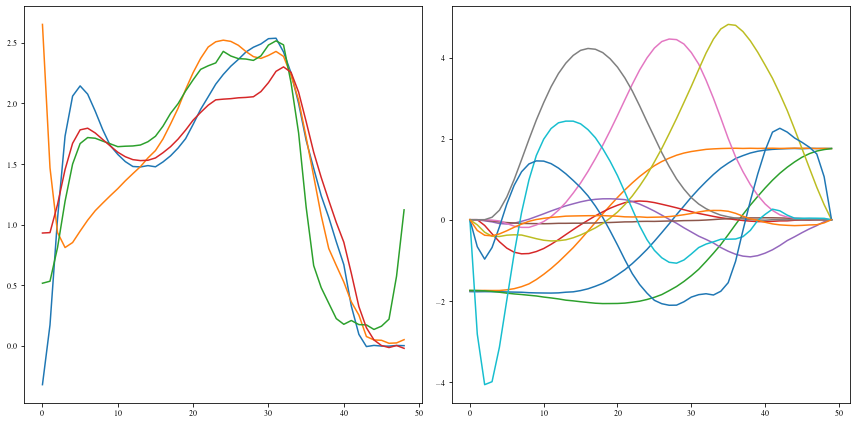

In [16]:
selected_expert = expert_gating_network.predict(x_query).argmax()
print("Selected expert", selected_expert)

fig = plt.figure()
fig.set_size_inches(12,6)
plt.subplot(121)
s = time.time()
U_guess = control_experts[selected_expert].predict(x_query).reshape(control_time_dim,control_dim)
e = time.time()
print("MoE control expert prediction took", e-s)
plt.plot(U_guess)
plt.subplot(122)
s = time.time()
X_guess = state_experts[selected_expert].predict(x_query).reshape(state_dim,time_dim).T
e = time.time()
print("MoE state expert prediction took", e-s)
plt.plot(X_guess)
plt.tight_layout()
plt.show()

In [17]:
# for selected_expert in range(num_clusters):
#     fig = plt.figure(selected_expert)
#     pred = experts[selected_expert].predict(x_query)
#     plt.plot(pred.reshape(control_time_dim,control_dim))
# plt.show()

# Evaluate warm-starts

In [18]:
# # Figure out prediction error
# test_me = 123

# X_ground_truth = np.matrix(samples_X[test_me,:6,0])
# Y_ground_truth = samples_U[test_me]
# print(X_ground_truth)

# fig = plt.figure()
# fig.set_size_inches(10,6)
# # Ground-truth
# # plt.plot(Y_ground_truth, label='Ground-truth')

# # Direct learning
# Y_direct_learning = direct_learning_model.predict(X_ground_truth).reshape(control_time_dim,control_dim)
# error_direct_learning = Y_ground_truth - Y_direct_learning
# plt.plot(error_direct_learning, label='direct learning error', color='green')

# # KNN Regressor
# Y_knn_regressor = knn_regressor_model.predict(X_ground_truth).reshape(control_time_dim,control_dim)
# error_knn_regressor = Y_ground_truth - Y_knn_regressor
# plt.plot(error_knn_regressor, label='KNN regressor error', color='blue')

# # Discrete MoE
# Y_discrete_moe = experts[expert_gating_network.predict(X_ground_truth).argmax()].predict(X_ground_truth).reshape(control_time_dim,control_dim)
# error_discrete_moe = Y_ground_truth - Y_discrete_moe
# plt.plot(error_discrete_moe, label='Discrete-MoE error', color='yellow')

# # Weighted discrete MoE
# Y_discrete_moe_weighted = np.zeros((Y_train.shape[1],)).T
# Y_discrete_moe_weighted_weighting = expert_gating_network.predict(X_ground_truth)
# for i in range(num_clusters):
#     Y_discrete_moe_weighted += Y_discrete_moe_weighted_weighting[0,i] * experts[i].predict(X_ground_truth).reshape(Y_train.shape[1],)
# Y_discrete_moe_weighted = Y_discrete_moe_weighted.reshape(control_time_dim,control_dim)
# error_discrete_moe_weighted = Y_ground_truth - Y_discrete_moe_weighted
# plt.plot(error_discrete_moe_weighted, label='Discrete-MoE (weighted) error', color='purple')

# plt.tight_layout()
# plt.legend()
# plt.show()

In [19]:
def direct_learning_warmstart(x_query):
    return direct_learning_model_state.predict(x_query).reshape(state_dim, time_dim), direct_learning_model_control.predict(x_query).reshape(control_time_dim, control_dim)

def knn_regressor_warmstart(x_query):
    return knn_regressor_model_state.predict(x_query).reshape(state_dim, time_dim), knn_regressor_model_control.predict(x_query).reshape(control_time_dim, control_dim)

def coldstart(x_query):
    mass = 0.5
    g = 9.81
    gravity_compensation_per_rotor = mass * g / 4.
    U_coldstart = gravity_compensation_per_rotor * np.ones((control_time_dim, control_dim))
    return None, U_coldstart

# def separately_trained_moe_warmstart(x_query):
def proposed_method_warmstart(x_query):
    selected_expert = expert_gating_network.predict(x_query).argmax()
    return state_experts[selected_expert].predict(x_query).reshape(state_dim, time_dim), control_experts[selected_expert].predict(x_query).reshape(control_time_dim, control_dim)

# Benchmark on random problems

In [20]:
import pyexotica as exo

# OMPL to check start states
ompl = exo.Setup.load_solver('{topological_memory_clustering}/examples/quadrotor/resources/quadrotor_rrt.xml')
ompl_scene = ompl.get_problem().get_scene()

In [22]:
def test_warm_start(start_state, U_init, X_init, do_initial_rollout=False):
    solver = exo.Setup.load_solver('{topological_memory_clustering}/examples/quadrotor/resources/quadrotor_maze.xml')
    problem = solver.get_problem()
    solver.debug_mode = False

    if U_init is not None:
        problem.U = U_init.T

    tmp_start_state = problem.start_state.copy()
    tmp_start_state[:6] = start_state
    problem.start_state = tmp_start_state
    tmp_X = problem.X.copy()
    if X_init is not None:
        tmp_X[:X_init.shape[0],:] = X_init
    tmp_X[:6,0] = start_state
    problem.X = tmp_X

    #if do_initial_rollout:
    #    for t in range(problem.T - 1):
    #        problem.update(problem.U[:,t],t)

    solver.max_iterations = 1000
    traj = solver.solve()
    '''
    plt.figure()
    plt.plot(solver.control_cost_evolution,label='control')
    plt.plot(problem.get_cost_evolution()[1],label='total')
    plt.legend()
    plt.yscale('log')
    plt.show()
    '''
    return problem.get_cost_evolution()

In [23]:
def test_warm_start_return_rollout(start_state, U_init, X_init):
    assert U_init is not None
    #assert X_init is not None

    solver = exo.Setup.load_solver('{topological_memory_clustering}/examples/quadrotor/resources/quadrotor_maze.xml')
    problem = solver.get_problem()
    solver.debug_mode = False

    problem.U = U_init.T

    tmp_start_state = problem.start_state.copy()
    tmp_start_state[:6] = start_state
    problem.start_state = tmp_start_state
    tmp_X = problem.X.copy()
    if X_init is not None:
        tmp_X[:X_init.shape[0],:] = X_init
    tmp_X[:6,0] = start_state
    problem.X = tmp_X

    for t in range(problem.T - 1):
        problem.update(problem.U[:,t],t)
    X_initial_roll_out = problem.X.copy()
    
    # Reset with warm-start
    problem.X = tmp_X

    solver.max_iterations = 1000
    traj = solver.solve()
    
    X_optimised = problem.X.copy()
    
    return problem.get_cost_evolution(), X_init, X_initial_roll_out, X_optimised

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


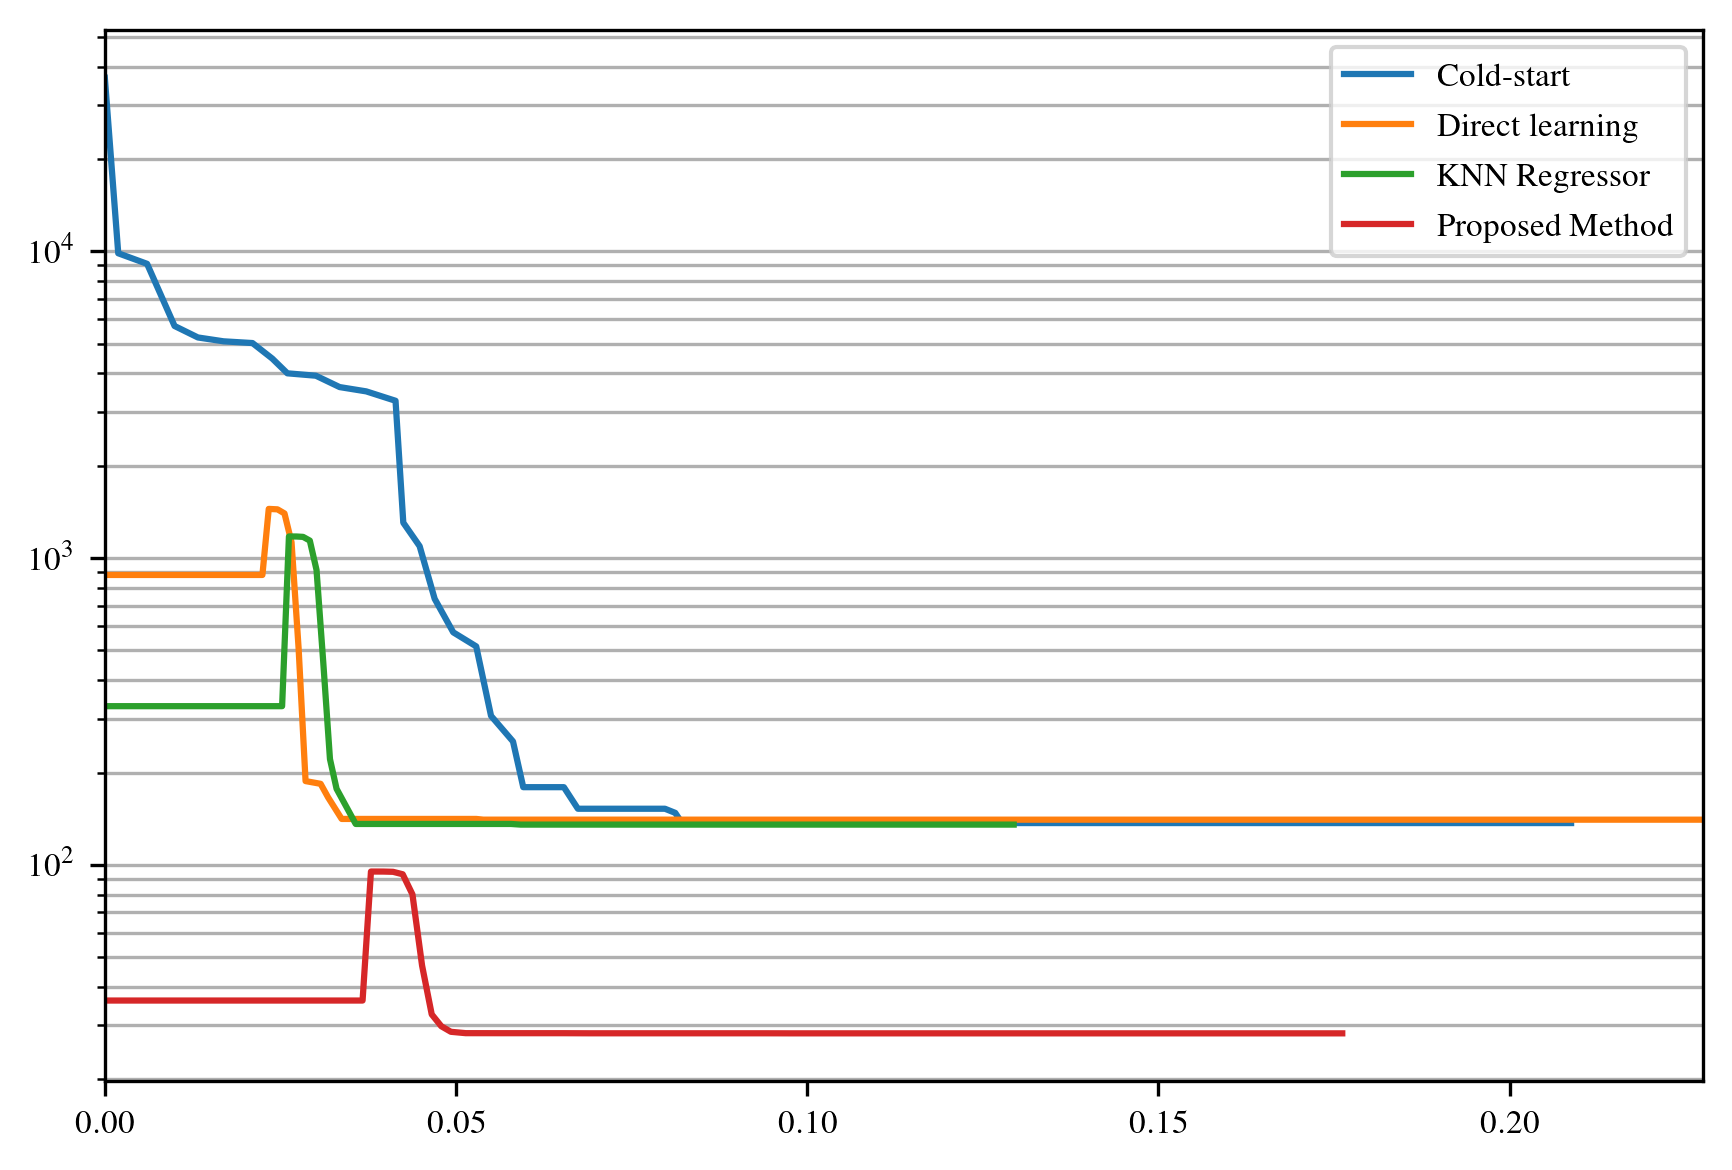

In [24]:
x_query = np.zeros((12,))
x_query[:3] = np.array([-1.75,-1.75,-1.75]).T
x_query[:3] += np.random.uniform(low=-1.25,high=1.25,size=(3,))

warmstarting_methods = OrderedDict({
    'Cold-start': coldstart,
    'Direct learning': direct_learning_warmstart,
    'KNN Regressor': knn_regressor_warmstart,
    'Proposed Method': proposed_method_warmstart,
})

fig, ax = plt.subplots()
fig.set_dpi(300)

U_coldstart = coldstart(None)[1]

ret_max = 0
for label in warmstarting_methods:
    y_warmstart = warmstarting_methods[label](x_query.reshape(1,-1))
    ret = test_warm_start(x_query[:6], y_warmstart[1], y_warmstart[0], do_initial_rollout=False)
    #ret = test_warm_start(x_query, U_init=U_coldstart, X_init=y_warmstart[0])
    
    plt.plot(ret[0],ret[1], label=label)
    if ret[0][-1] > ret_max:
        ret_max = ret[0][-1]

plt.legend()
plt.tight_layout()
plt.xlim(0,ret_max)
ax.set_yscale('log')
ax.grid(which='both',axis='y')
plt.show()

# Big benchmark

In [25]:
from tqdm import tqdm

In [26]:
import exotica_ddp_solver_py

In [27]:
def get_valid_random_start_state():
    start_state_valid = False
    start_state_original = np.zeros((12,)) #problem.start_state.copy()
    start_state_original[:3] = -1.75
    while not start_state_valid:
        start_state = start_state_original.copy()
        start_state[0:3] += np.random.uniform(low=-1.,high=1.,size=(3,))

        # check initial state
        ompl_scene.set_model_state(start_state[:6])
        start_state_valid = ompl_scene.is_state_valid()
        if not start_state_valid:
            print(i, "start state in collision, resampling")
    return start_state

In [52]:
num_test_cases = 500

np.random.seed(1)
benchmark_results_random_cost = OrderedDict({})
benchmark_results_random_times = OrderedDict({})
for label in warmstarting_methods:
    benchmark_results_random_cost[label] = []
    benchmark_results_random_times[label] = []

for i in tqdm(range(num_test_cases)):
    x_query = get_valid_random_start_state()
    
    for label in warmstarting_methods:
        y_warmstart = warmstarting_methods[label](x_query.reshape(1,-1))
        ret = test_warm_start(x_query[:6], y_warmstart[1], y_warmstart[0])
        #ret = test_warm_start(x_query[:6], U_coldstart, y_warmstart[0])
        #ret = test_warm_start(x_query[:6], y_warmstart[1], None)
        ret_stretch = np.zeros((1001,))
        ret_stretch[:] = np.nan
        ret_stretch[:len(ret[1])] = ret[1]
        benchmark_results_random_cost[label].append(ret_stretch.copy())
        ret_stretch[:len(ret[0])] = ret[0]
        benchmark_results_random_times[label].append(ret_stretch.copy())

100%|██████████| 500/500 [05:27<00:00,  1.53it/s]


In [109]:
# benchmark_results_random_cost, benchmark_results_random_times
np.savez('202102_benchmark_results', benchmark_results_random_cost=benchmark_results_random_cost, benchmark_results_random_times=benchmark_results_random_times)

KeyboardInterrupt: 

<ipython-input-54-dc13cea86164>:8: RuntimeWarning: Mean of empty slice
  y_mean = np.nanmean(benchmark_results_random_cost[label], axis=0)
/usr/local/lib/python3.8/dist-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


plotting Cold-start
plotting Direct learning
plotting KNN Regressor
plotting Proposed Method


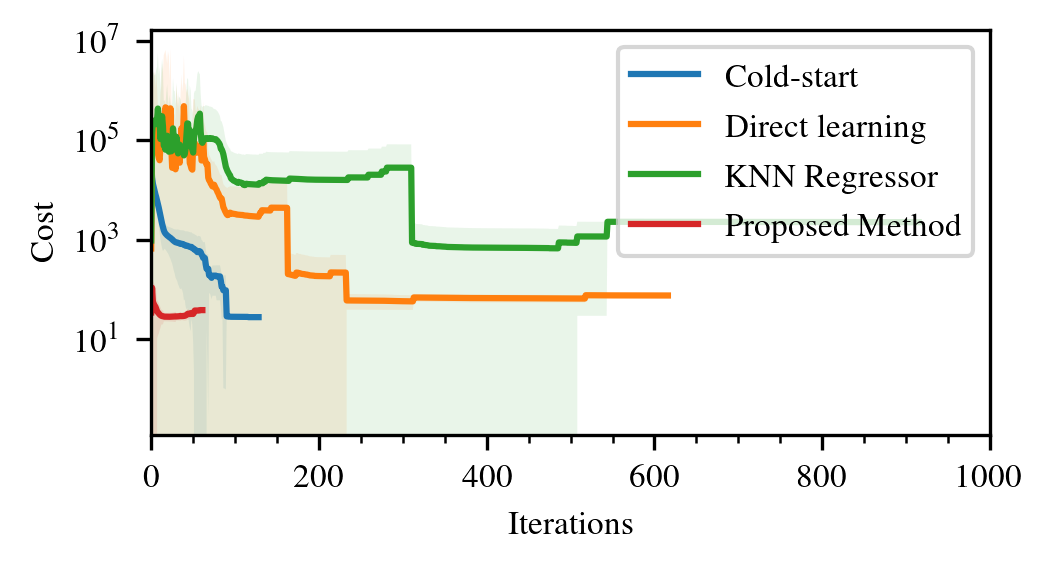

In [54]:
fig, ax = plt.subplots()
fig.set_dpi(300)
fig.set_size_inches(3.5, 2)
x = range(1001)

for label in benchmark_results_random_cost:
    print("plotting", label)
    y_mean = np.nanmean(benchmark_results_random_cost[label], axis=0)
    y_std = np.nanstd(benchmark_results_random_cost[label], axis=0)
    y_plus_std = y_mean + y_std
    y_minus_std = y_mean - y_std
    plt.plot(x, y_mean, label=label)
    ax.fill_between(x, y_minus_std, y_plus_std, alpha=0.1)
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.tight_layout()
plt.minorticks_on()
plt.xlim(0,1000)
plt.show()

# fig.savefig('plot/warmstart_benchmark_model_comparison_cost_over_iterations_12d_prediction.pdf')

#### Average number of iterations

Cold-start Iterations: 36.31 +/- 14.73	 Time: 0.14 +/- 0.05
Direct learning Iterations: 37.59 +/- 42.65	 Time: 0.14 +/- 0.13
KNN Regressor Iterations: 41.27 +/- 61.93	 Time: 0.15 +/- 0.20
Proposed Method Iterations: 31.10 +/- 7.87	 Time: 0.12 +/- 0.03
Success rate for Cold-start 0.024
Success rate for MLP 0.172
Success rate for KNN Regr. 0.264
Success rate for Proposed 0.998


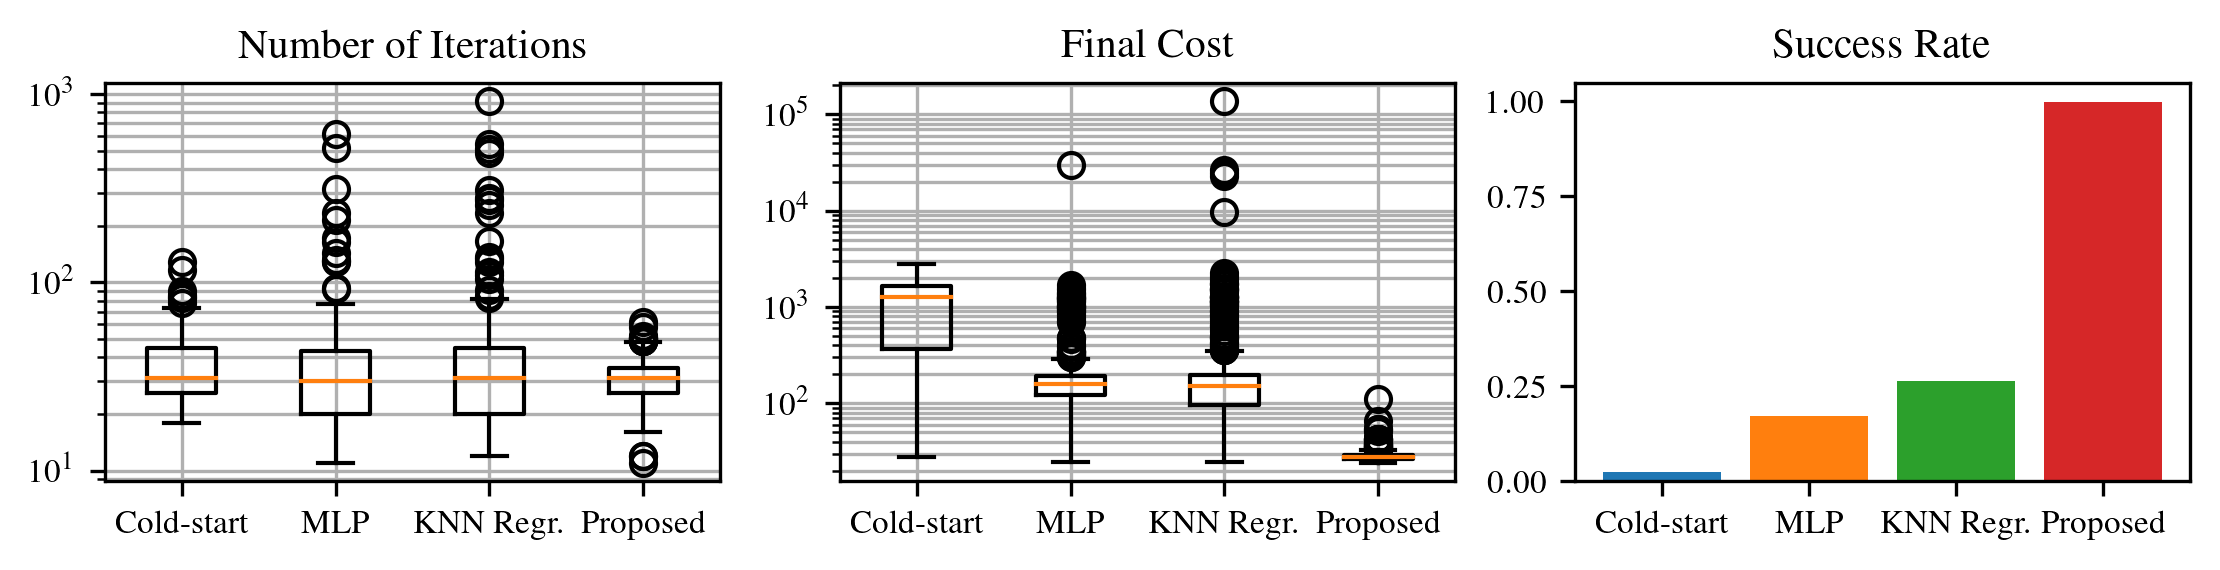

In [81]:
success_rate_cost_threshold = 100

avg_iterations = OrderedDict({})
final_costs = OrderedDict({})
convergence_times = OrderedDict({})
success_rates = OrderedDict({})
short_labels = {'Proposed Method': 'Proposed', 'KNN Regressor': 'KNN Regr.', 'Direct learning': 'MLP'}
for label in benchmark_results_random_cost:
    avg_iterations_tmp = np.zeros((len(benchmark_results_random_cost[label]),))
    final_costs_tmp = np.zeros((len(benchmark_results_random_cost[label]),))
    convergence_times_tmp = np.zeros((len(benchmark_results_random_times[label]),))
    for i in range(len(benchmark_results_random_cost[label])):
        avg_iterations_tmp[i] = np.count_nonzero(~np.isnan(benchmark_results_random_cost[label][i]))
        first_nonnan = np.where((np.isnan(benchmark_results_random_cost[label][i]))==True)[0][0] - 1
        final_costs_tmp[i] = benchmark_results_random_cost[label][i][first_nonnan]
        convergence_times_tmp[i] = benchmark_results_random_times[label][i][first_nonnan]

    print(label, "Iterations: {0:.2f} +/- {1:.2f}\t Time: {2:.2f} +/- {3:.2f}".format(avg_iterations_tmp.mean(), avg_iterations_tmp.std(), convergence_times_tmp.mean(), convergence_times_tmp.std()))
    avg_iterations[label] = avg_iterations_tmp.copy()
    final_costs[label] = final_costs_tmp.copy()
    convergence_times[label] = convergence_times_tmp.copy()
    success_rates[label] = np.count_nonzero(final_costs[label] < success_rate_cost_threshold) / np.count_nonzero(final_costs[label])

labels_for_boxplot = []
for key in avg_iterations.keys():
    if key in short_labels:
        labels_for_boxplot.append(short_labels[key])
    else:
        labels_for_boxplot.append(key)
    
fig = plt.figure()
fig.set_dpi(300)
fig.set_size_inches(7.5,2)
plt.subplot(131)
plt.title('Number of Iterations', fontsize=10)
plt.boxplot(avg_iterations.values(), labels=labels_for_boxplot)
plt.yscale('log')
# plt.ylabel('Iterations')
plt.grid(which='both')

plt.subplot(132)
plt.title('Final Cost', fontsize=10)
plt.boxplot(final_costs.values(), labels=labels_for_boxplot)
plt.yscale('log')
plt.grid(which='both')

plt.subplot(133)
# plt.title('Time to Convergence', fontsize=10)
# plt.boxplot(convergence_times.values(), labels=labels_for_boxplot)
# # plt.yscale('log')
# plt.grid(which='both')

plt.title('Success Rate', fontsize=10)
i = 0
for label in success_rates:
    plt.bar(x=labels_for_boxplot[i], height=success_rates[label])
    print("Success rate for", labels_for_boxplot[i], success_rates[label])
    i+=1

plt.tight_layout()
plt.show()

# fig.savefig('plot/warmstart_benchmark_model_comparison_iterations_final_cost_convergence_time.pdf')

Cold-start 27.850417233033035 2830.4872400486893 682.7403546787327
Direct learning 24.38780229617888 29534.2133697132 1332.3920495624718
KNN Regressor 24.50969179279606 136903.81770131996 6410.8070464965085
Proposed Method 24.072143005865282 110.2864105375603 5.256839098710143


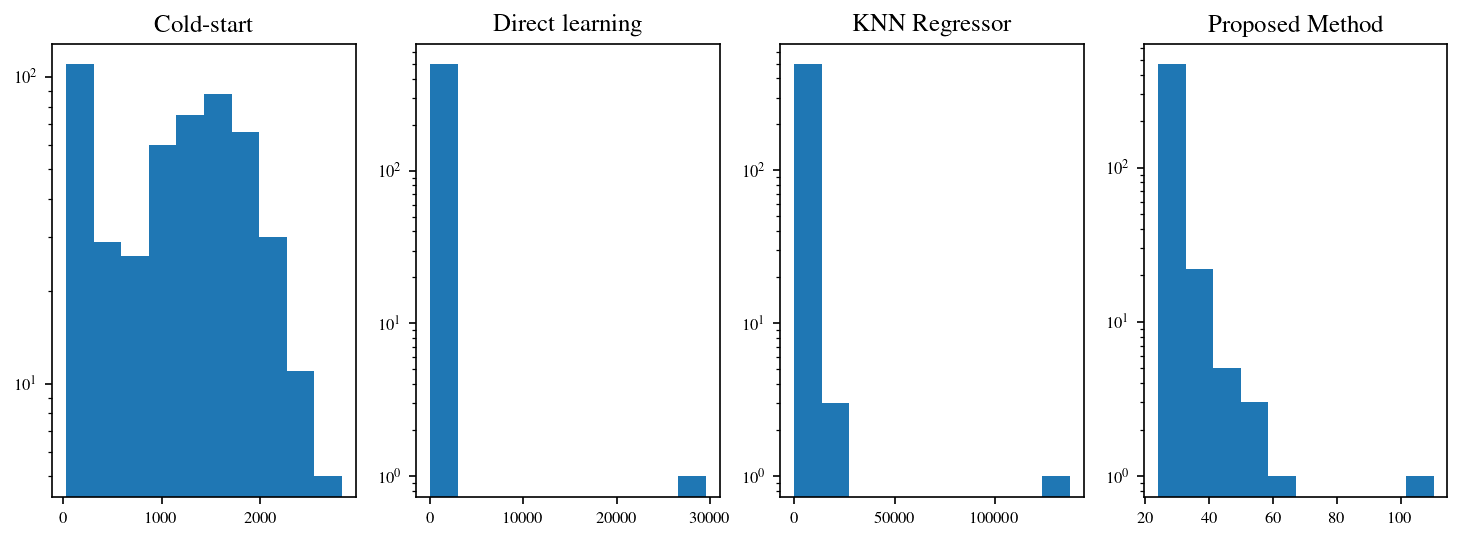

In [57]:
fig = plt.figure()
fig.set_size_inches(12, 4)
fig.set_dpi(150)
num_methods = len(final_costs.keys())
i = 1
final_costs_for_plot = final_costs.copy()
max_threshold = 1e6
for label in final_costs:
    plt.subplot(1, num_methods, i)
    plt.title(label)
    i += 1
    final_costs_for_plot[label] = final_costs_for_plot[label][final_costs_for_plot[label] < max_threshold]
    print(label, np.min(final_costs_for_plot[label]), np.max(final_costs_for_plot[label]), np.std(final_costs_for_plot[label]))
    plt.hist(final_costs_for_plot[label])
    plt.yscale('log')

## Plot but only including the successful runs

Cold-start Iterations: 36.31 +/- 14.73	 Time: 0.14 +/- 0.05
Direct learning Iterations: 37.59 +/- 42.65	 Time: 0.14 +/- 0.13
KNN Regressor Iterations: 41.27 +/- 61.93	 Time: 0.15 +/- 0.20
Proposed Method Iterations: 31.10 +/- 7.87	 Time: 0.12 +/- 0.03
Success rate for Cold-start 0.024
Success rate for MLP 0.172
Success rate for KNN Regr. 0.264
Success rate for Proposed 0.998


/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


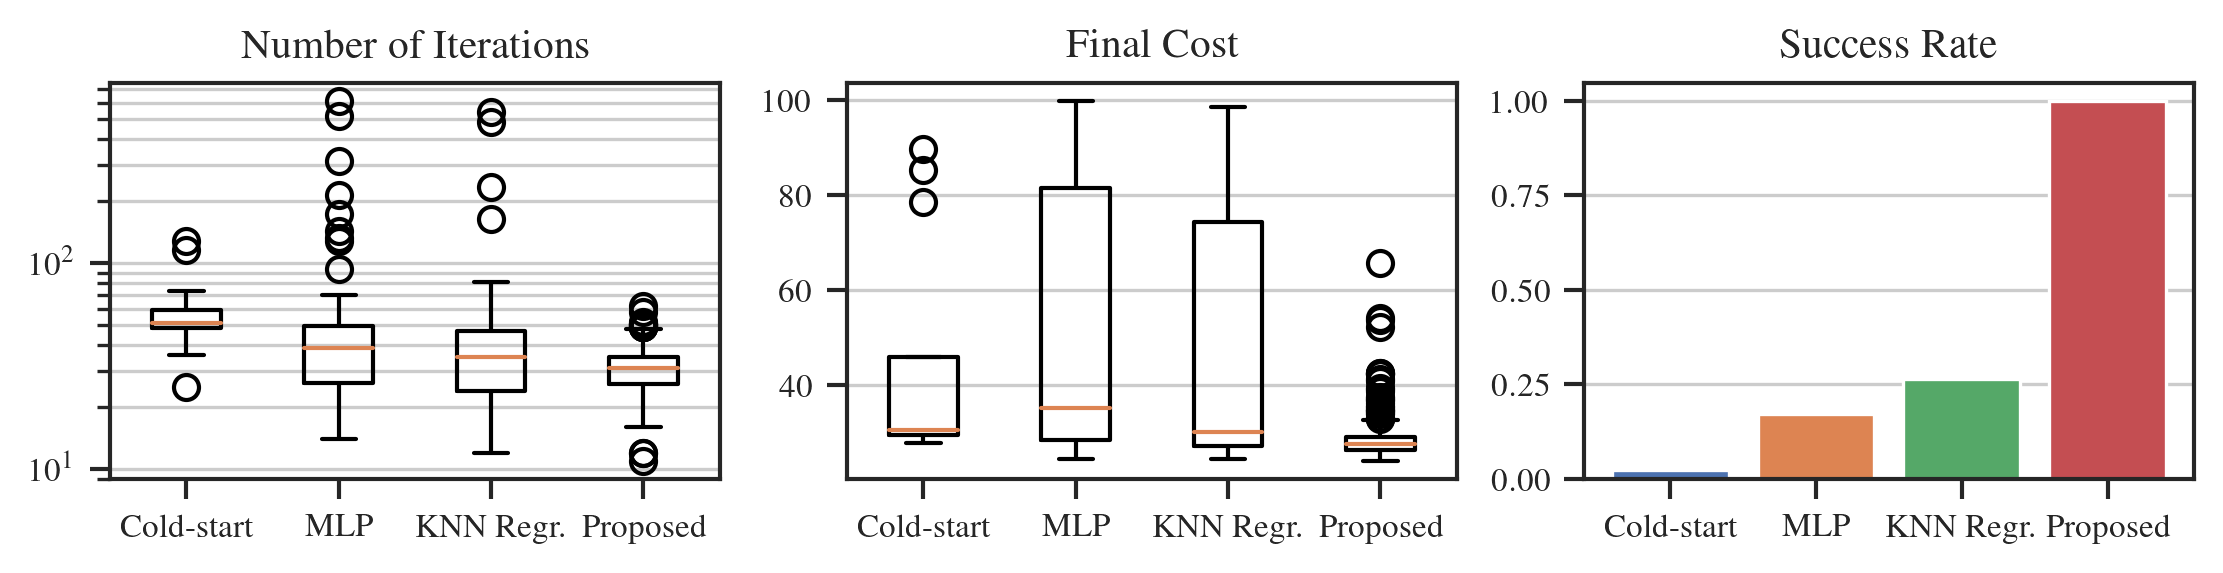

In [107]:
success_rate_cost_threshold = 100

avg_iterations = OrderedDict({})
final_costs = OrderedDict({})
convergence_times = OrderedDict({})
success_rates = OrderedDict({})
short_labels = {'Proposed Method': 'Proposed', 'KNN Regressor': 'KNN Regr.', 'Direct learning': 'MLP'}
for label in benchmark_results_random_cost:
    avg_iterations_tmp = np.zeros((len(benchmark_results_random_cost[label]),))
    final_costs_tmp = np.zeros((len(benchmark_results_random_cost[label]),))
    convergence_times_tmp = np.zeros((len(benchmark_results_random_times[label]),))
    for i in range(len(benchmark_results_random_cost[label])):
        avg_iterations_tmp[i] = np.count_nonzero(~np.isnan(benchmark_results_random_cost[label][i]))
        first_nonnan = np.where((np.isnan(benchmark_results_random_cost[label][i]))==True)[0][0] - 1
        final_costs_tmp[i] = benchmark_results_random_cost[label][i][first_nonnan]
        convergence_times_tmp[i] = benchmark_results_random_times[label][i][first_nonnan]

    print(label, "Iterations: {0:.2f} +/- {1:.2f}\t Time: {2:.2f} +/- {3:.2f}".format(avg_iterations_tmp.mean(), avg_iterations_tmp.std(), convergence_times_tmp.mean(), convergence_times_tmp.std()))
    avg_iterations[label] = avg_iterations_tmp.copy()
    final_costs[label] = final_costs_tmp.copy()
    convergence_times[label] = convergence_times_tmp.copy()
    success_rates[label] = np.count_nonzero(final_costs[label] < success_rate_cost_threshold) / np.count_nonzero(final_costs[label])

labels_for_boxplot = []
for key in avg_iterations.keys():
    if key in short_labels:
        labels_for_boxplot.append(short_labels[key])
    else:
        labels_for_boxplot.append(key)
    
fig = plt.figure()
fig.set_dpi(300)
fig.set_size_inches(7.5,2)
plt.subplot(131)
plt.title('Number of Iterations', fontsize=10)
avg_iterations_only_successful = {}
for label in avg_iterations.keys():
    avg_iterations_only_successful[label] = avg_iterations[label][final_costs[label] < success_rate_cost_threshold]
plt.boxplot(avg_iterations_only_successful.values(), labels=labels_for_boxplot)
#plt.boxplot(avg_iterations.values(), labels=labels_for_boxplot)
plt.yscale('log')
# plt.ylabel('Iterations')
plt.grid(which='both', axis='y')

plt.subplot(132)
plt.title('Final Cost', fontsize=10)
final_costs_only_successful = {}
for label in final_costs.keys():
    final_costs_only_successful[label] = final_costs[label][final_costs[label] < success_rate_cost_threshold]
plt.boxplot(final_costs_only_successful.values(), labels=labels_for_boxplot)
# plt.boxplot(final_costs.values(), labels=labels_for_boxplot)
# plt.yscale('log')
plt.grid(which='both', axis='y')

plt.subplot(133)
# plt.title('Time to Convergence', fontsize=10)
# plt.boxplot(convergence_times.values(), labels=labels_for_boxplot)
# plt.yscale('log')

plt.title('Success Rate', fontsize=10)
i = 0
for label in success_rates:
    plt.bar(x=labels_for_boxplot[i], height=success_rates[label])
    print("Success rate for", labels_for_boxplot[i], success_rates[label])
    i+=1
plt.grid(which='both', axis='y')

plt.tight_layout()
plt.show()

# fig.savefig('plot/warmstart_benchmark_model_comparison_iterations_final_cost_success_rate.eps')

-----

In [82]:
for label in benchmark_results_random_cost:
    avg_iterations = np.zeros((len(benchmark_results_random_cost[label]),))
    for i in range(len(benchmark_results_random_cost[label])):
        avg_iterations[i] = np.count_nonzero(~np.isnan(benchmark_results_random_cost[label][i]))

    print(label, "{0:2} +/- {1:2}".format(avg_iterations.mean(), avg_iterations.std()))

Cold-start 36.306 +/- 14.730253358309897
Direct learning 37.594 +/- 42.64838993443949
KNN Regressor 41.268 +/- 61.9302848047706
Proposed Method 31.1 +/- 7.872610748665274


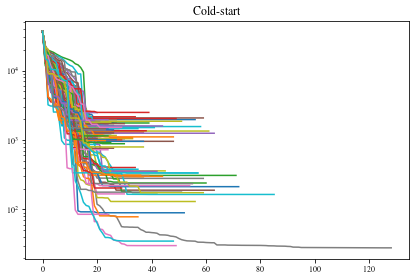

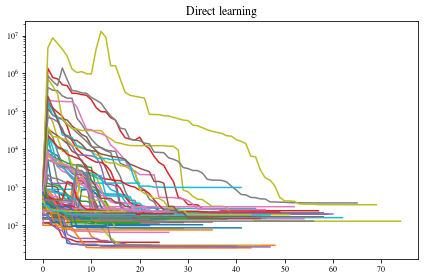

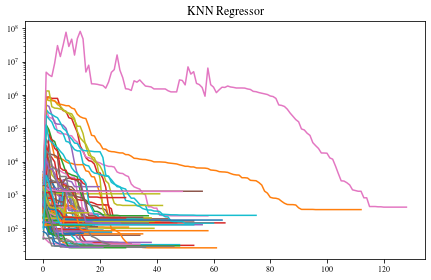

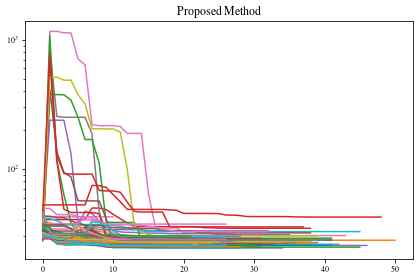

In [83]:
# sns.lineplot(x="timepoint", y="signal", data=benchmark_results_random['Cold-start'])
i = 0
for label in warmstarting_methods:
    fig = plt.figure(i + 1)
    plt.title(label)
    for j in range(100):
        plt.plot(benchmark_results_random_cost[label][j][:], label=label)
    plt.tight_layout()
    plt.yscale('log')
    i += 1
#plt.legend()

plt.show()

# Use Pandas to get plot with time vs cost and shaded region

In [84]:
avg_iterations = OrderedDict({})
final_costs = OrderedDict({})
convergence_times = OrderedDict({})
short_labels = {'Proposed Method': 'Proposed', 'KNN Regressor': 'KNN Regr.', 'Direct learning': 'MLP'}

s = time.time()
method_dfs = OrderedDict({})
for label in benchmark_results_random_cost:
    print("Method", label)
    df = pd.DataFrame(columns=['dt'] + [str(i) for i in range(num_test_cases)])

    all_dts = []
    for i in range(num_test_cases):
        first_nan = np.where((np.isnan(benchmark_results_random_times[label][i]))==True)[0][0]
        all_dts += benchmark_results_random_times[label][i][:first_nan].tolist()
    
    all_dts = np.unique(np.array(all_dts))
    #all_dts = pd.to_timedelta(all_dts, unit='s')
    df['dt'] = all_dts
    df = df.set_index('dt')

    for i in range(num_test_cases):
        first_nan = np.where((np.isnan(benchmark_results_random_times[label][i]))==True)[0][0]
        for j in range(first_nan):
            df[str(i)][benchmark_results_random_times[label][i][j]] = benchmark_results_random_cost[label][i][j]

    df = df.fillna(method='pad')
    
    if label == 'Direct learning':
        label = 'MLP'

    method_dfs[label] = df.copy()
e = time.time()
print("Processing took {0:.2f}s".format(e-s))

Method Cold-start
Method Direct learning
Method KNN Regressor
Method Proposed Method
Processing took 10.13s


In [87]:
s = time.time()
insert_me = []
breakme = 0
for method in method_dfs.keys():
    df2 = method_dfs[method]
    method_name = method
    if method_name in short_labels:
        method_name = short_labels[method_name]
    for column in df2.columns:
        sample = int(column)
        iteration = 0
        for i in df2[column].iteritems():
            #insert_me.append((method, sample, iteration, i[0].total_seconds(), i[1]))
            insert_me.append((method, sample, iteration, i[0], i[1]))
            iteration += 1
        #breakme+=1
        #if breakme==10:
        #    break
df_new = pd.DataFrame(insert_me, columns=['Method', 'Sample', 'Iteration', 'Time (s)', 'Cost'])
e = time.time()
print("Processing took {0:.2f}s".format(e-s))

Processing took 26.17s


In [88]:
df_new.shape

(35568500, 5)

In [90]:
# df_new.to_pickle('20210223_quadrotor_benchmark_results_200neurons_mlp_FCL.pkl')

In [91]:
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set()
sns.set_context("paper")
sns.set_style("ticks") # whitegrid, ticks

In [92]:
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8) # 10
plt.rc('ytick', labelsize=8) # 10
plt.rc('axes', labelsize=8) # 10
plt.rc('legend', fontsize=8) # 10

In [97]:
df_new['Time (s)'].max()

3.239348958

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


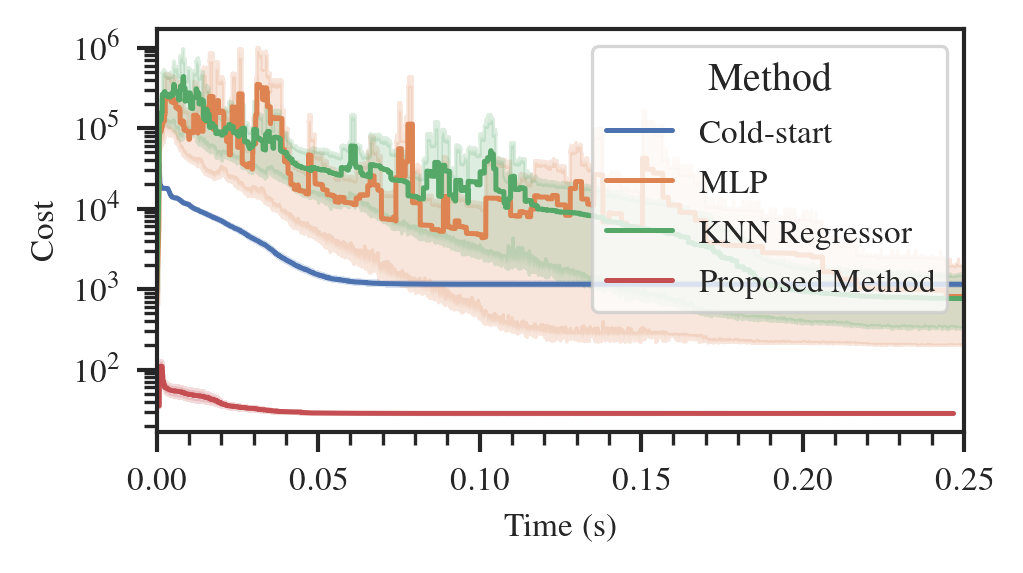

Plotting took 1279.8984928131104


In [93]:
s = time.time()
fig = plt.figure()
fig.set_dpi(300)
fig.set_size_inches(3.5, 2)
# sns.relplot(x='dt', y='cost', hue='method', kind='line', data=df_new)
sns.lineplot(x='Time (s)', y='Cost', hue='Method', data=df_new)
plt.yscale('log')
plt.xlim(0, .25)
plt.minorticks_on()
plt.tight_layout()
plt.show()
e = time.time()
print("Plotting took", e-s)

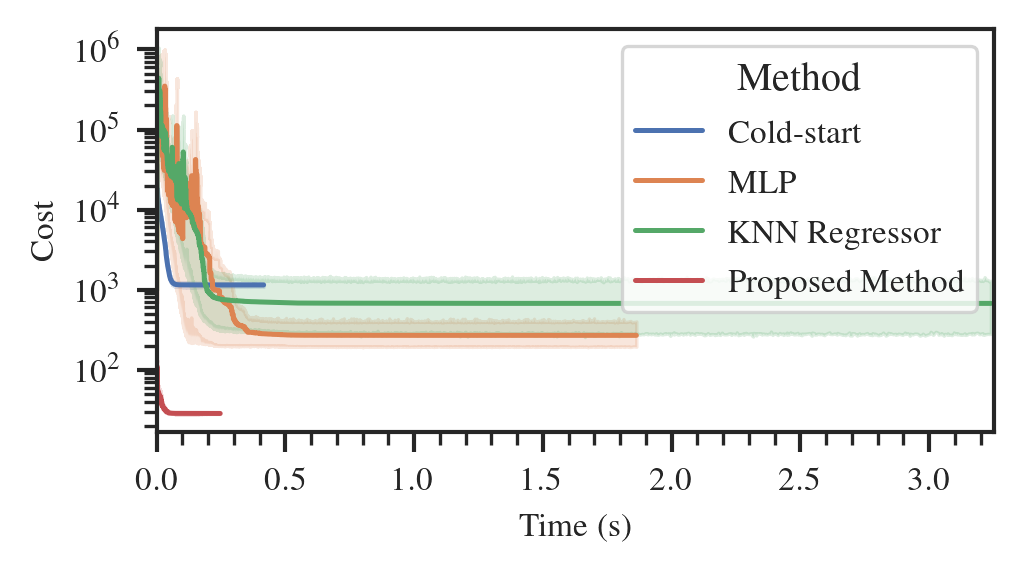

Plotting took 1476.3703179359436


In [98]:
s = time.time()
fig = plt.figure()
fig.set_dpi(300)
fig.set_size_inches(3.5, 2)
# sns.relplot(x='dt', y='cost', hue='method', kind='line', data=df_new)
sns.lineplot(x='Time (s)', y='Cost', hue='Method', data=df_new)
plt.yscale('log')
plt.xlim(0, 3.25)
plt.minorticks_on()
plt.tight_layout()
plt.show()
e = time.time()
print("Plotting took", e-s)

In [108]:
fig.savefig('plot/quadrotor_learning_benchmark_cost_vs_time_3s.eps')

# Get network information

In [83]:
direct_learning_model_control.summary(), direct_learning_model_state.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 180)               2340      
_________________________________________________________________
dense_5 (Dense)              (None, 180)               32580     
_________________________________________________________________
dense_6 (Dense)              (None, 196)               35476     
Total params: 70,396
Trainable params: 70,396
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 180)               2340      
_________________________________________________________________
dense_2 (Dense)              (None, 180)               32580     
____________________________

(None, None)

In [84]:
70396+143520

213916

In [86]:
expert_gating_network.summary()
print(len(state_experts), state_experts[0].summary())
print(len(control_experts), control_experts[0].summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 100)               1300      
_________________________________________________________________
dense_32 (Dense)             (None, array(6))          606       
Total params: 1,906
Trainable params: 1,906
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                650       
_________________________________________________________________
dense_8 (Dense)              (None, 600)               30600     
Total params: 31,250
Trainable params: 31,250
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
___

# Visualise: X_pred, rollout(U_pred), X* for each of the learning methods

The idea here is that if we visualise the predicted state trajectory and the roll-out from the predicted control trajectory, we can get a visual intuition on the "dynamic defects".

In [26]:
from topological_memory_clustering.quadrotor import plot_state_trajectories_3d

In [43]:
def plot_state_trajectory_3d(X_to_plot, color=None, label=None, alpha=0.5, ax=None, plot_obstacle=True):
    if ax is None:
        ax = plt.axes(projection='3d')
    ax.plot3D(X_to_plot[0,:], X_to_plot[1,:], X_to_plot[2,:], color=color, alpha=alpha, label=label)

    # Bars
    if plot_obstacle:
        tmp_values = np.arange(-5,5.25,.25)
        tmp_zeros = np.zeros_like(tmp_values)
        obstacle_color = 'black'
        ax.plot3D(tmp_zeros, tmp_values, tmp_zeros, color=obstacle_color, linewidth=5, alpha=0.5)
        ax.plot3D(tmp_values, tmp_zeros, tmp_zeros, color=obstacle_color, linewidth=5, alpha=0.5)
        ax.plot3D(tmp_zeros, tmp_zeros, tmp_values, color=obstacle_color, linewidth=5, alpha=0.5)

    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_zlim(-5,5)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)
    return fig

In [169]:
def make_comparison_plot(x_query, i):
    for label in warmstarting_methods:
        #print(label)
        y_warmstart = warmstarting_methods[label](x_query.reshape(1,-1))
        cost_evolution, X_init, X_initial_roll_out, X_optimised = test_warm_start_return_rollout(x_query[:6], y_warmstart[1], y_warmstart[0])

        fig = plt.figure()
        fig.set_dpi(300)
        fig.set_size_inches(1920./300., 1080./300.)
        ax = plt.axes(projection='3d')

        if X_init is None:
            X_init = x_query.reshape(-1,1).repeat(50, axis=1)

        plot_state_trajectory_3d(X_init, label=r'$X_{pred}$', ax=ax, plot_obstacle=True)
        plot_state_trajectory_3d(X_initial_roll_out, label=r'$X_{rollout}$', ax=ax, plot_obstacle=False)
        plot_state_trajectory_3d(X_optimised, label='$X_{optimised}$', ax=ax, plot_obstacle=False)

        if "Direct" not in label:
            plt.title(label)
        else:
            plt.title('MLP')
        plt.tight_layout()
        plt.legend(loc='upper right')
        #plt.show()

        fig.savefig(os.path.join('/tmp', 'QuadrotorWarmstarts', label, '{:06d}.png'.format(i)))
        plt.close(fig)

In [91]:
import os
import sys
from tqdm import tqdm

In [108]:
exo.Setup.init_ros()

In [141]:
vis_problem = exo.Setup.load_solver('{topological_memory_clustering}/examples/quadrotor/resources/quadrotor_maze.xml').get_problem()
vis_scene = vis_problem.get_scene()
vis_scene.update(np.zeros((vis_problem.N,)))
vis_scene.get_kinematic_tree().publish_frames()

In [155]:
def publish_scene():
    vis_problem = exo.Setup.load_solver('{topological_memory_clustering}/examples/quadrotor/resources/quadrotor_maze.xml').get_problem()
    vis_scene = vis_problem.get_scene()
    vis_scene.update(np.zeros((vis_problem.N,)))
    vis_scene.get_kinematic_tree().publish_frames()

In [132]:
import rospy
from visualization_msgs.msg import MarkerArray

rospy.init_node('vis')
pub = rospy.Publisher('/quadrotor_paths', MarkerArray, queue_size=1)

In [145]:
from jsk_rviz_plugins.srv import Screenshot, ScreenshotRequest, ScreenshotResponse

rospy.wait_for_service('/rviz/screenshot')
screenshot = rospy.ServiceProxy('/rviz/screenshot', Screenshot)

In [165]:
def make_comparison_plot_rviz(x_query, i):
    for label in warmstarting_methods:
        #print(label)
        y_warmstart = warmstarting_methods[label](x_query.reshape(1,-1))
        cost_evolution, X_init, X_initial_roll_out, X_optimised = test_warm_start_return_rollout(x_query[:6], y_warmstart[1], y_warmstart[0])

        publish_scene()
        
        if X_init is None:
            X_init = x_query.reshape(-1,1).repeat(50, axis=1)

        X_stacked = np.vstack([[X_init.T], [X_initial_roll_out.T], [X_optimised.T]])[:,:,:3]
        ma = topological_memory_clustering.rviz.get_quadrotor_paths_as_marker_array(X_stacked, [0, 1, 2])
        for i in range(len(ma.markers)):
            ma.markers[i].color.a = 1.0
            ma.markers[i].scale.x = 0.1
        pub.publish(ma)
        time.sleep(0.5)
        filename = os.path.join('/tmp', 'QuadrotorWarmstartsRviz', label, '{:06d}.png'.format(i))
        screenshot(filename)
        time.sleep(0.5)

In [160]:
for label in warmstarting_methods:
    os.makedirs(os.path.join('/tmp/', 'QuadrotorWarmstarts', label))
    os.makedirs(os.path.join('/tmp/', 'QuadrotorWarmstartsRviz', label))

In [170]:
# Step through x, y, z in valid space to get the trajectories & visualise
i = 0
step = 0.01
for x in tqdm(np.arange(-1.75-1.5, -1.75+1.5, step).tolist()):
    for y in [-1.75]: #np.arange(-1.75-1.5, -1.75+1.5, step).tolist():
        for z in [-1.75]: #np.arange(-1.75-1.5, -1.75+1.5, step).tolist():
            x_query = np.zeros((12,))
            x_query[:3] = np.array([x, y, z]).T

            make_comparison_plot(x_query, i)
            #make_comparison_plot_rviz(x_query, i)
            i += 1

# x_query = np.zeros((12,))
# x_query[:3] = np.array([-1.75,-1.75,-1.75]).T
# x_query[:3] += np.random.uniform(low=-1.5,high=1.5,size=(3,))

100%|██████████| 300/300 [18:34<00:00,  3.71s/it]


In [171]:
for label in warmstarting_methods:
    os.chdir(os.path.join('/tmp/', 'QuadrotorWarmstarts', label))
    #a = os.popen('pwd').read()
    outfile = os.path.expanduser("~/Desktop/exploring_x_{0}.mp4".format(label.replace(" ", "_")))
    print("Converting to: ", outfile)
    out = os.popen("ffmpeg -r 15 -f image2 -i %06d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p " + outfile).read()
    print(out)

Converting to:  /home/wxm/Desktop/exploring_x_Direct_learning.mp4

Converting to:  /home/wxm/Desktop/exploring_x_Proposed_Method.mp4

Converting to:  /home/wxm/Desktop/exploring_x_KNN_Regressor.mp4

Converting to:  /home/wxm/Desktop/exploring_x_Cold-start.mp4

